# DCGAN on the MNIST Dataset

In [1]:
import tempfile
import os
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import layers
from matplotlib import pyplot as plt
import fastestimator as fe
from fastestimator.backend import binary_crossentropy, feed_forward
from fastestimator.dataset.data import mnist
from fastestimator.op import LambdaOp
from fastestimator.op.numpyop.univariate import ExpandDims, Normalize
from fastestimator.op.tensorop import TensorOp
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.trace.io import ModelSaver

In [2]:
batch_size = 256
epochs = 50
max_train_steps_per_epoch = None
save_dir = tempfile.mkdtemp()
model_name = 'model_epoch_50.h5'

In [3]:
# Parameters
epochs = 5
batch_size = 8
max_train_steps_per_epoch = 10
model_name = "model_epoch_5.h5"


<h2>Building components</h2>

### Step 1: Prepare training and define a `Pipeline`

We are loading data from tf.keras.datasets.mnist and defining a series of operations to perform on the data before the training:

In [4]:
train_data, _ = mnist.load_data()
pipeline = fe.Pipeline(
    train_data=train_data,
    batch_size=batch_size,
    ops=[
        ExpandDims(inputs="x", outputs="x"),
        Normalize(inputs="x", outputs="x", mean=1.0, std=1.0, max_pixel_value=127.5),
        LambdaOp(fn=lambda: np.random.normal(size=[100]).astype('float32'), outputs="z")
    ])

### Step 2: Create a `model` and FastEstimator `Network`

First, we have to define the network architecture for both our <b>Generator</b> and <b>Discriminator</b>. After defining the architecture, users are expected to feed the architecture definition, along with associated model names and optimizers, to fe.build.

In [5]:
def generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

In [6]:
def discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [7]:
gen_model = fe.build(model_fn=generator, optimizer_fn=lambda: tf.optimizers.Adam(1e-4))
disc_model = fe.build(model_fn=discriminator, optimizer_fn=lambda: tf.optimizers.Adam(1e-4))

We define the generator and discriminator losses. These can have multiple inputs and outputs.

In [8]:
class GLoss(TensorOp):
    """Compute generator loss."""
    def forward(self, data, state):
        return binary_crossentropy(y_pred=data, y_true=tf.ones_like(data), from_logits=True)

In [9]:
class DLoss(TensorOp):
    """Compute discriminator loss."""
    def forward(self, data, state):
        true_score, fake_score = data
        real_loss = binary_crossentropy(y_pred=true_score, y_true=tf.ones_like(true_score), from_logits=True)
        fake_loss = binary_crossentropy(y_pred=fake_score, y_true=tf.zeros_like(fake_score), from_logits=True)
        total_loss = real_loss + fake_loss
        return total_loss

`fe.Network` takes series of operators. Here we pass our models wrapped into `ModelOps` along with our loss functions and some update rules:

In [10]:
network = fe.Network(ops=[
        ModelOp(model=gen_model, inputs="z", outputs="x_fake"),
        ModelOp(model=disc_model, inputs="x_fake", outputs="fake_score"),
        GLoss(inputs="fake_score", outputs="gloss"),
        UpdateOp(model=gen_model, loss_name="gloss"),
        ModelOp(inputs="x", model=disc_model, outputs="true_score"),
        DLoss(inputs=("true_score", "fake_score"), outputs="dloss"),
        UpdateOp(model=disc_model, loss_name="dloss")
    ])

### Step 3: Prepare `Estimator` and configure the training loop

We will define an `Estimator` that has four notable arguments: network, pipeline, epochs and traces. Our `Network` and `Pipeline` objects are passed here as an argument along with the number of epochs and a `Trace`, in this case one designed to save our model every 5 epochs.

In [11]:
traces=ModelSaver(model=gen_model, save_dir=save_dir, frequency=5)

In [12]:
estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=epochs,
                         traces=traces,
                         max_train_steps_per_epoch=max_train_steps_per_epoch)

<h2>Training</h2>

In [13]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        



FastEstimator-Start: step: 1; num_device: 0; logging_interval: 100; 


FastEstimator-Train: step: 1; dloss: 1.3402084; gloss: 0.67782855; 
FastEstimator-Train: step: 10; epoch: 1; epoch_time: 0.98 sec; 


FastEstimator-Train: step: 20; epoch: 2; epoch_time: 0.66 sec; 


FastEstimator-Train: step: 30; epoch: 3; epoch_time: 0.64 sec; 


FastEstimator-Train: step: 40; epoch: 4; epoch_time: 0.64 sec; 


FastEstimator-ModelSaver: Saved model to /tmp/tmpy64ho1fb/model_epoch_5.h5
FastEstimator-Train: step: 50; epoch: 5; epoch_time: 0.75 sec; 
FastEstimator-Finish: step: 50; total_time: 4.43 sec; model_lr: 1e-04; model1_lr: 1e-04; 


<h2>Inferencing</h2>

For inferencing, first we have to load the trained model weights. We will load the trained generator weights using <i>fe.build</i>

In [14]:
model_path = os.path.join(save_dir, model_name)
trained_model = fe.build(model_fn=generator, weights_path=model_path, optimizer_fn=lambda: tf.optimizers.Adam(1e-4))

We will the generate some images from random noise:

In [15]:
images = feed_forward(trained_model, np.random.normal(size=(16, 100)), training=False)

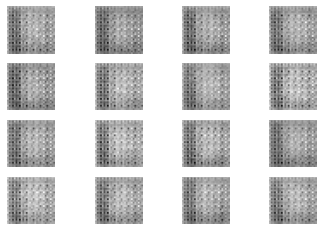

In [16]:
fig, axes = plt.subplots(4, 4)
axes = np.ravel(axes)
for i in range(images.shape[0]):
    axes[i].axis('off')
    axes[i].imshow(np.squeeze(images[i, ...] * 127.5 + 127.5), cmap='gray')